# Visualize monthly changes in Hirakund reservoir using video

## Table of Contents
* [Introduction](#Introduction)
* [Necessary Imports](#Necessary-Imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
* [Function to create collection of images with desired time intervals](#Function-to-create-collection-of-images-with-desired-time-intervals)
* [Make video from image collection](#Make-video-from-image-collection)
* [Conclusion](#Conclusion)

## Introduction

The World is changing daily. Major changes like shrinking of lakes, river path shifts, construction of megastructures can be seen directly from the satellite images. This notebook creates a movie to visualize monthly changes in Hirakund reservoir, Odisha.

First, let's import all the necessary libraries and connect to our GIS via an existing profile or creating a new connection by e.g. ```gis = GIS("https://www.arcgis.com", "username", "Password").```

**Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

```
conda install -c anaconda pillow
conda install -c conda-forge imageio
```

## Necessary Imports

In [1]:
!conda install -c anaconda pillow -y

In [2]:
!conda install -c conda-forge imageio=2.7 -y

In [3]:
import os
import imageio
import pandas as pd
import datetime as dt
from platform import system
from PIL import Image, ImageFont, ImageDraw

import arcgis
from arcgis.gis import GIS
from arcgis import geometry, geocode
from arcgis.raster.functions import apply

## Connect to your GIS

In [4]:
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

## Get the data for analysis

Search for Multispectral Landsat layer in ArcGIS Online.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
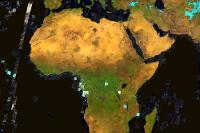

In [5]:
landsat_item = ent_gis.content.get('d9b466d6a9e647ce8d1dd5fe12eb434b')
landsat = landsat_item.layers[0]
landsat_item

Applying Natural color to the filtered Landsat collection using predefined `apply` function

In [6]:
rgb_collection = apply(landsat, 'Natural Color with DRA')

In [14]:
g = geocode('Hirakund reservoir, Odisha', out_sr=3857)[0]
extent = g.get('extent')

In [7]:
m = ent_gis.map('Hirakund reservoir, Odisha, India')
m.basemap = 'satellite'
m

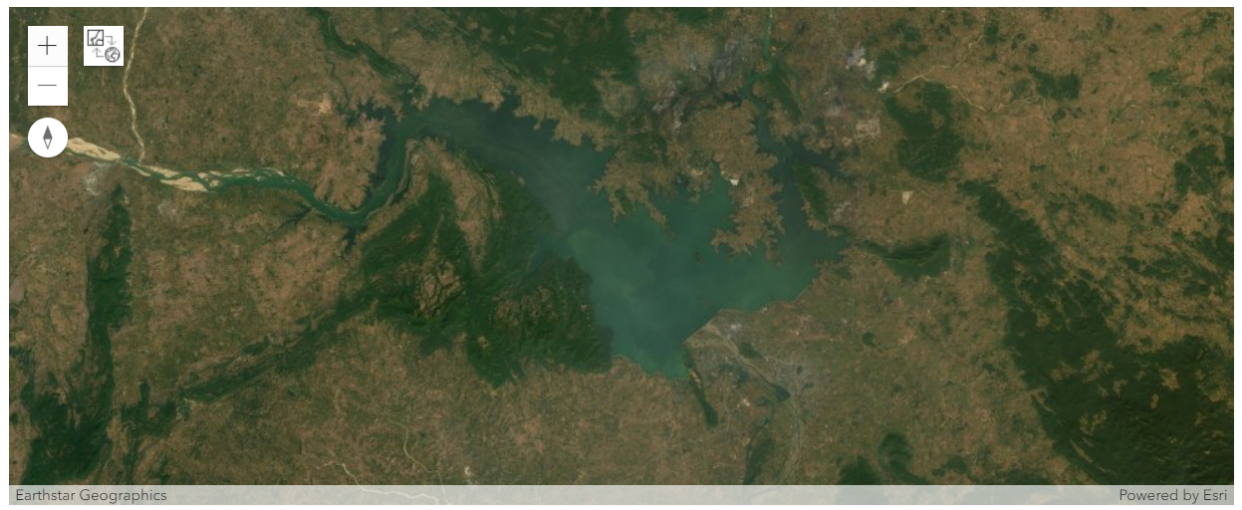

## Function to create collection of images with desired time intervals

The function below creates an array of images with the desired time intervals. If a user specifies 'm' then the images in the selected collection will be consolidated on a monthly basis i.e. all the images of the specified extent will be mosaicked monthly and if the user specifies 'y' as the interval then the images in the selected collection will be consolidated on yearly basis.

In [8]:
from functools import lru_cache

@lru_cache(maxsize=50)
def load_font():
    try:
        if system()=='Windows':
            return ImageFont.truetype("arial.ttf", 30)
        elif system()=='Linux':
            return ImageFont.truetype("~/.fonts/truetype/dejavu/DejaVuSans.ttf", 30)
        else:
            return ImageFont.truetype("Arial.ttf", 30)
    except:
        return ImageFont.load_default()

In [9]:
def collection(df, interval, start, end, height, width):
    images=[]
    if(interval=='m'):                                                                                     # monthly
        for i in range(int(start.split('-')[0]), int(end.split('-')[0])+1):
            for j in range(1,13):
                selected = df[(df['AcquisitionDate'].dt.year == i) & (df['AcquisitionDate'].dt.month == j)]
                id = selected['OBJECTID'].values.tolist()
                if(len(id)>0):
                    rgb_collection.mosaic_by(method="LockRaster",lock_rasters=id)
                    img_name = 'img_'+str(i)+"-"+str(j)+".jpg"
                    rgb_collection.export_image(bbox=extent, size=[height,width], f='image', 
                                                  save_folder='.', 
                                                  save_file=img_name)
                    img = Image.open(img_name).convert('RGB')
                    font = load_font()
                    draw = ImageDraw.Draw(img)
                    draw.text((550, 0),str(j)+"-"+str(i),(255,255,255),font=font)
                    images.append(img)
                    os.remove(img_name)
                    
    elif(interval=='y'):                                                                                  # yearly
        for i in range(int(start.split('-')[0]), int(end.split('-')[0])+1):
            selected = df[df['AcquisitionDate'].dt.year == i]
            id = selected['OBJECTID'].values.tolist()
            if(len(id)>0):
                rgb_collection.mosaic_by(method="LockRaster",lock_rasters=id)
                img_name = 'img_'+str(i)+".jpg"
                rgb_collection.export_image(bbox=extent, size=[height,width], f='image', 
                                              save_folder='.', 
                                              save_file=img_name)
                img = Image.open(img_name).convert('RGB')
                font = load_font()
                draw = ImageDraw.Draw(img)
                draw.text((550, 0),str(i),(255,255,255),font=font)    
                images.append(img)
                os.remove(img_name)
    
    return images

## Make video from image collection

The function below will generate a movie (gif) from the collection saved from the above step.

In [10]:
def create_movie(target, interval, start, end, height, width, extent, duration):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d')
    end_date = dt.datetime.strptime(end, '%Y-%m-%d')
    selected = target.filter_by(where="(Category = 1) AND (CloudCover <=0.5)",
                             time=[start_date, end_date],
                             geometry=arcgis.geometry.filters.intersects(extent))

    df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                        order_by_fields="AcquisitionDate").sdf
    df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
    frames = collection(df, interval, start, end, height, width)
    imageio.mimsave('/arcgis/home/movie'+'_'+interval+'.gif', frames, duration=duration)
    print("Movie Created")

In [15]:
create_movie(rgb_collection,'m' ,'2019-01-01','2019-12-31', 1250, 450, extent, 0.4)          # calling create_movie function

Movie Created


The movie (gif) will be created in the same directory where your notebook exists. The gif below is generated using the code above which shows how the Hirakund reservoir in Odisha, India changed monthly in the year 2019.

![SegmentLocal](../../static/img/movie_m.gif "segment")

## Conclusion

The sample notebook shows how you can animate an Imagery Layer over time to get a visual detail of the change that has happened on any given extent, either monthly or annually. You can bring any image collection that you have or use the image service provided by Esri Living Atlas and run this notebook against it. This can be repeated for any other location and for any other time interval by changing the `extent` variable and the `time` interval when calling the `create_movie()` function.